In [18]:
# COMENZAMOS CON EL ENTRENAMIENTO DE LOS MODELOSfrom sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sys import path
sys.path.append('C:\\Users\\Laura\\Desktop\\Nueva carpeta\\Code\\util')

from funciones import graficos_conf_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix,recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pickle

In [19]:
# IMPORTAMOS EL CSV YA LIMPIO .
# LO VAMOS A DIVIDIR EN DOS, UNA PARTE PARA EL ENTRENAMIENTO-PREDICCIONES Y OTRA PARTE PARA EL TEST, COMO SI DE DATOS REALES SE TRATARAN


data_train = pd.read_csv('../Data/Processed/data_processed.csv', index_col=0)

data_train = data_train.iloc[:int(data_train.shape[0]*60/100), :]
data_test = data_train.iloc[int(data_train.shape[0]*60/100) : , :]

In [20]:
# DIVIDIMOS EN DATA_TRAIN EN TRAIN Y TEST


X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns=['Target','Anxiety','Stress'], axis=1), data_train.Target, random_state=0, test_size=0.20, shuffle=True)



RANDOM FOREST

In [ ]:
# CREACION DE PIPELINE INICIAL.
# HACEMOS UN RANDOMIZE CON CROSS VALIDATIION PORQUE TARDA MENOS
# LO INSTANCIAMOS
model_rf = RandomForestClassifier() 


params = {'n_estimators' : range(100,500,100),
           'criterion': ['gini', 'entropy'],
           'max_depth':range(2,5),
           'max_leaf_nodes':range(2,10),
           'min_samples_split':range(50,300,50),
           'random_state' : [42],
            }


random_forest_gtc = RandomizedSearchCV(model_rf, params, cv=5, scoring='accuracy', n_iter=100)
random_forest_gtc.fit(X_train, y_train)

In [ ]:
# SACAMOS LOS MEJORES PARÁMETROS PARA ENTRENAR EL MODELO

print (random_forest_gtc.best_params_)
print (random_forest_gtc.best_estimator_)

{'random_state': 42, 'n_estimators': 100, 'min_samples_split': 50, 'max_leaf_nodes': 5, 'max_depth': 4, 'criterion': 'gini'}
RandomForestClassifier(max_depth=4, max_leaf_nodes=5, min_samples_split=50,
                       random_state=42)


In [ ]:
#CREAMOS UN NUEVO PIPELINE CON EL RESULTADO MEJOR RESULTADO DEL GRIDSEARCH
model_rf_V1 = random_forest_gtc.best_estimator_

In [ ]:
model_rf_V1

RandomForestClassifier(max_depth=4, max_leaf_nodes=5, min_samples_split=50,
                       random_state=42)

In [ ]:
# ENTRENAMOS EL MODELO Y SACAMOS LAS PREDICCIONES
model_rf_V1
model_rf_V1.fit(X_train,y_train)
y_predi = model_rf_V1.predict(X_test)

In [ ]:
# PASAMOS LAS METRICAS A UN DATAFRAM

df_scores = pd.read_csv('../Model/scores_models_Accu.csv', index_col=0)
df_scores['rf_train'] =[recall_score(y_test,y_predi), roc_auc_score(y_test,y_predi),  accuracy_score(y_test, y_predi), f1_score(y_test, y_predi)]


df_scores

In [ ]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_train = confusion_matrix(y_test, y_predi)

In [ ]:
# GUARDAMOS EL MODELO

with open('../Model/model_rf_V1', 'wb') as archivo_salida:
    pickle.dump(model_rf_V1, archivo_salida)

In [ ]:
# PROBAMOS EL MODELO CON LOS DATOS RESERVADOS PARA VER COMO GENERALIZA

X = data_test.drop(columns=['Target','Anxiety','Stress'], axis=1)
y= data_test.Target

with open('../Model/model_rf_V1', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [ ]:
loaded_model

RandomForestClassifier(max_depth=4, max_leaf_nodes=5, min_samples_split=50,
                       random_state=42)

In [ ]:
# PASAMOS LAS METRICAS A UN DATAFRAM
df_scores['rf_test'] =[recall_score(y,loaded_model.predict(X)), roc_auc_score(y,loaded_model.predict(X)), accuracy_score(y, loaded_model.predict(X)), f1_score(y, loaded_model.predict(X))]
df_scores.to_csv('../Model/scores_models_Accu.csv')
df_scores

In [ ]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_test = confusion_matrix(y,loaded_model.predict(X))

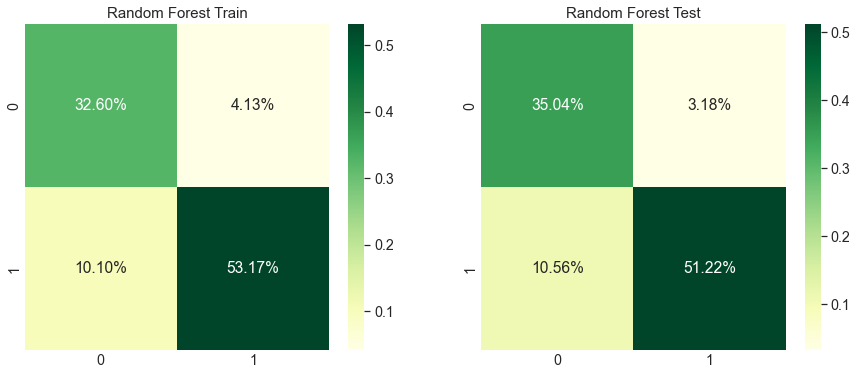

In [ ]:
graf_rf_A_matriz = plt.figure(figsize=(15,6))


plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,1)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_train,'Random Forest Train')


plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,2)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_test,'Random Forest Test')


graf_rf_A_matriz.savefig ('../util/Graficos/graf_rf_A_matriz.png')